In [1]:
# this code should be hidden, ignore this cell
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(0)
np.set_printoptions(precision=2,suppress=True)
plt.close('all')
red='#ff0000'

# ================================================= data

def get_test_data(D=3):
    multipliers = np.array([0.4])      # 2D
    if D>2:
        multipliers = np.array([0.2, 0.8]) # 3D
    N=30
    x_range=3
    noise=1.5
    offset=np.random.uniform(noise, size=multipliers.size+1)+x_range+1

    X = np.random.uniform(x_range*2, size=N) - x_range
    X = X[:,np.newaxis]
    for i in range(multipliers.size):
        n = X[:,0] * multipliers[i]
        n += np.random.uniform(noise*2, size=N) - noise
        X = np.column_stack((X, n) )
    X+=offset
    return X

def get_feature_selection_matrix(X,D):
    covar = np.cov(X.T)
    dia = np.diagonal(covar)
    index = list(range(dia.size))
    index.sort(key=lambda i: dia[i],reverse=True)
    P = np.zeros(covar.shape, dtype=int)
    for i in range(D):
        P[index[i],index[i]]=1
    mask = np.any(P!=0,axis=0)
    PP = P[mask,:]
    return P, PP
    
# ================================================= Visualization

def min_max(X,extra=0.3):
    return np.min([np.min(X),0])-extra, np.max(X)+extra

def set_limits(ax,X,extra=0.3):
    Xmin, Xmax = min_max(X)
    if X.shape[1]==1:
        ax.set_xlim(Xmin, Xmax)
        ax.set_ylim( -extra, +extra )
    elif X.shape[1]==2:
        ax.set_xlim(Xmin, Xmax)
        ax.set_ylim(Xmin, Xmax)
    else:
        ax.set_xlim(Xmin, Xmax)
        ax.set_ylim(Xmin, Xmax)
        ax.set_zlim(Xmin, Xmax)

def draw_plane(ax,X,axis="xy"):
    if X.shape[1]>2:
        Xmin, Xmax = min_max(X)
        dim1, dim2 = np.meshgrid([Xmin,Xmax], [Xmin,Xmax])
        zero = dim1*0
        if axis=="xz":
            ax.plot_surface(dim1, zero, dim2, alpha=0.1)
        elif axis=="yz":
            ax.plot_surface(zero, dim1, dim2, alpha=0.1)
        else:
            ax.plot_surface(dim1, dim2, zero, alpha=0.1)
        
def draw_axis(ax,X):
    Xmin, Xmax = min_max(X,0)
    if X.shape[1]==1:
        ax.plot([0,Xmax],[0,0])
    elif X.shape[1]==2:
        ax.plot([0,Xmax],[0,0])
        ax.plot([0,0],[0,Xmax])
    else:
        ax.plot([0,Xmax],[0,0],[0,0])
        ax.plot([0,0],[0,Xmax],[0,0])
        ax.plot([0,0],[0,0],[0,Xmax])
        
def set_labels(ax,X):
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if X.shape[1]>2:
        ax.set_zlabel('z')
        
def draw_points(ax,X,mark='o',color='#1f77b4'):
    if X.shape[1]==1:
        X = np.column_stack((X, np.zeros(X.shape[0])))
    if X.shape[1]==2:
        ax.scatter(X[:,0], X[:,1], marker=mark, c=color)
    else:
        ax.scatter(X[:,0], X[:,1], X[:,2], marker=mark, c=color)

def draw_lines(ax,begin,end,color='b'):
    if begin.shape[1]==2:
        for i in range(begin.shape[0]):
            ax.plot( [begin[i][0],end[i][0]], [begin[i][1],end[i][1]] ,color)
    else:
        for i in range(begin.shape[0]):
            ax.plot( [begin[i][0],end[i][0]], [begin[i][1],end[i][1]], [begin[i][2],end[i][2]] ,color)
    
def plot_data(X):
    sns.set(style = "darkgrid")
    fig = plt.figure()
    if X.shape[1]<=2:
        ax = fig.add_subplot()
    else:
        ax = fig.add_subplot(projection='3d')
    draw_points(ax,X)
    set_limits(ax,X)
    draw_axis(ax,X)
    set_labels(ax,X)
    return fig,ax

def print_covar(covar):
    print("covariance matrix:")
    display(covar)
    if np.isscalar(covar) or covar.size==1:
        print("total variance:",f"{covar:.2f}")
    else:
        print("total variance:  ", 
              " + ".join([f"{i:.2f}" for i in np.diagonal(covar)]),
              "  =  ", f"{np.trace(covar):.2f}")
        
# ================================================= Ellipsiod

def polar_to_cartesian(rad):
    return np.array([np.cos(rad), np.sin(rad)])
polar_to_cartesian_vectorized = np.vectorize(polar_to_cartesian, signature='()->(n)')

def create_ellipsoid_2D(steps=41):
    rads = np.linspace(0.0, 2*np.pi, steps)
    return polar_to_cartesian_vectorized(rads)

def long_lat_to_r3(longitude, latitude):
    z = np.cos(longitude)
    y = np.sin(longitude)
    x = np.sin(latitude)
    m = np.sqrt(1 - x**2)
    return np.array([x, y*m, z*m])
long_lat_to_r3_vectorized = np.vectorize(long_lat_to_r3, signature='(),()->(n)')

def create_ellipsoid_3D(steps=9):
    longitude = np.linspace(0.0, 2*np.pi, steps)
    latitude = np.linspace(np.pi/2, -np.pi/2, steps)
    longitude, latitude = np.meshgrid(longitude, latitude)
    return long_lat_to_r3_vectorized(longitude, latitude)

def transform_vector(M, v):
    return np.matmul(M, v)
transform_vector_vectorized = np.vectorize(transform_vector, signature='(n,n),(n)->(n)')

def create_ellipsoid(covar, std=3):
    if covar.shape == (2,2):
        ellipsoid = create_ellipsoid_2D()
    else:
        ellipsoid = create_ellipsoid_3D()
    U, S, V = np.linalg.svd(covar)
    B = U * np.sqrt(S) * std
    return transform_vector_vectorized(B,ellipsoid)

def draw_ellipsoid(ax,ellipsoid,color='#1f77b4',linewidth=0.8):
    if len(ellipsoid.shape)==2:
        for i in range(ellipsoid.shape[0]-1):
            x1,y1 = ellipsoid[i]
            x2,y2 = ellipsoid[i+1]
            ax.plot([x1,x2], [y1,y2], c=color, linewidth=linewidth)
    else:
        ax.plot_wireframe(*(ellipsoid.T), colors=color, linewidths=linewidth)


# PCA Geometrically
author: Bas Terwijn

This notebook gives a geometric interpretation of Principal Component Analysis (PCA). PCA is a dimensionality reduction technique that preserves as much of the variance as possible. Variance is closely related to information, so you can think about is as preserving as much information as possible. **Geometrically PCA can be seen as merely doing a rotation before doing Feature Selection**.

In [2]:
# install 'ipympl' and reload notebook for interactive plots
%matplotlib widget

## Generate Data
Generate some test data with D dimensions to do dimensionality reduction on. In the examples below we will reduce the dimensionality by just 1 but the same logic applies in general for any reduction.

In [3]:
X = get_test_data( D=3 )  # use D=2 for 2D data 
display(X)

array([[5.5 , 5.56, 6.64],
       [6.11, 6.78, 7.01],
       [5.  , 5.36, 5.78],
       [6.04, 5.58, 5.71],
       [3.77, 5.12, 5.34],
       [3.41, 4.39, 3.57],
       [6.31, 5.5 , 7.37],
       [4.27, 5.73, 3.98],
       [5.58, 5.84, 6.05],
       [5.39, 5.28, 4.87],
       [3.6 , 6.2 , 4.19],
       [7.87, 5.84, 7.34],
       [7.79, 5.81, 8.67],
       [8.12, 6.8 , 8.45],
       [4.06, 6.15, 5.53],
       [4.33, 5.83, 5.39],
       [3.88, 5.64, 5.38],
       [3.33, 5.12, 4.55],
       [4.23, 5.57, 5.07],
       [5.92, 4.8 , 7.12],
       [4.32, 6.26, 4.59],
       [7.63, 6.71, 7.49],
       [5.03, 6.28, 6.01],
       [7.51, 5.79, 7.48],
       [3.5 , 5.79, 5.13],
       [5.62, 5.79, 5.86],
       [6.15, 6.34, 5.58],
       [6.9 , 6.66, 7.4 ],
       [4.35, 6.25, 4.67],
       [5.94, 5.47, 7.01]])

## Plot
Plot the data as points.

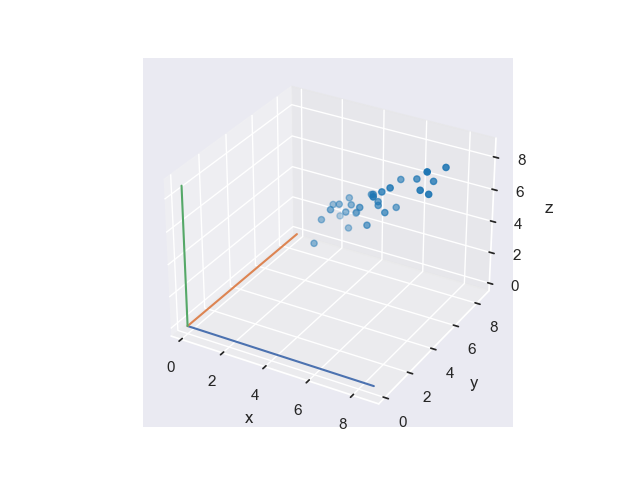

In [4]:
plot_data(X)
plt.show()

## Center
First step is to center the data by subtracting the mean.

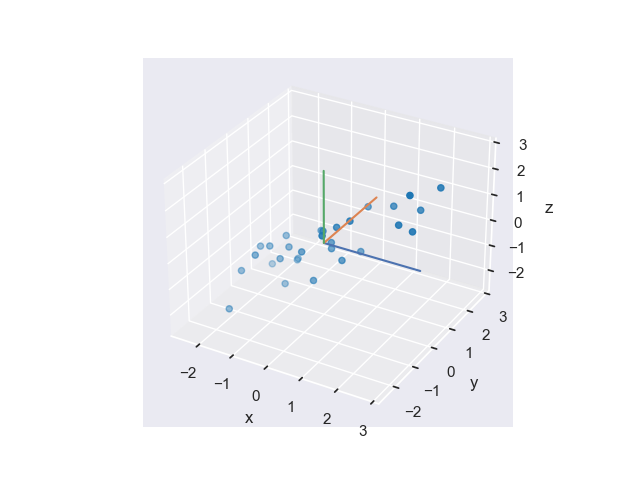

In [5]:
X -= np.mean(X,axis=0)
fig, ax = plot_data(X)
plt.show()

## Covariance of X
The covariance matrix of the data has on the diagonal the variance in x,y,... dimensions. Summing the diagonal gives the total variance of the data that we want to preserve as much as possible.

In [6]:
print_covar(np.cov(X.T))

covariance matrix:


array([[2.14, 0.34, 1.72],
       [0.34, 0.33, 0.27],
       [1.72, 0.27, 1.75]])

total variance:   2.14 + 0.33 + 1.75   =   4.22


## Feature Selection
The simplest form of dimensionality reduction is Feature Selection where you simply choose which dimensions we select and which we throw away. As we want to preserve the total variance we here select the dimensions with highest variance. The dimensions we select can be represented in a projection matrix P. 

In [7]:
P, PP = get_feature_selection_matrix(X, X.shape[1]-1)
print("P:")
display(P)
print("PP:")
display(PP)

P:


array([[1, 0, 0],
       [0, 0, 0],
       [0, 0, 1]])

PP:


array([[1, 0, 0],
       [0, 0, 1]])

Using P we can project the points in X to a plane as indicated in red:

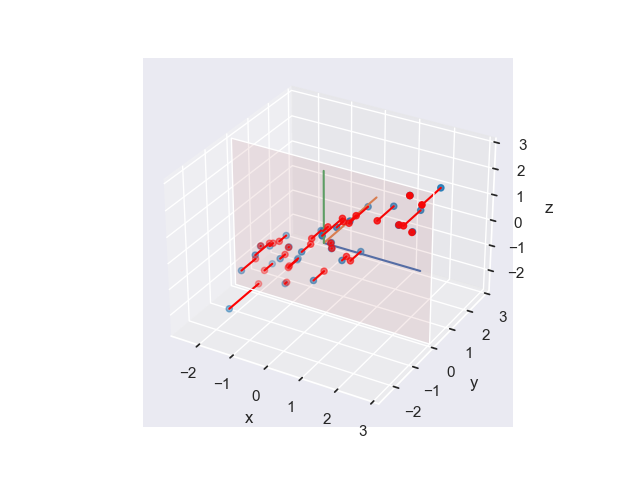

In [8]:
Z = np.matmul(P, X.T).T

fig,ax=plot_data(X)
draw_plane(ax, X, "xz")
draw_points(ax, Z, color=red)
draw_lines(ax, X, Z, color=red)
plt.show()

## Feature Selection result
Using PP we can compute Z which is X reduced by 1 dimension. Z are all the points in the plane.

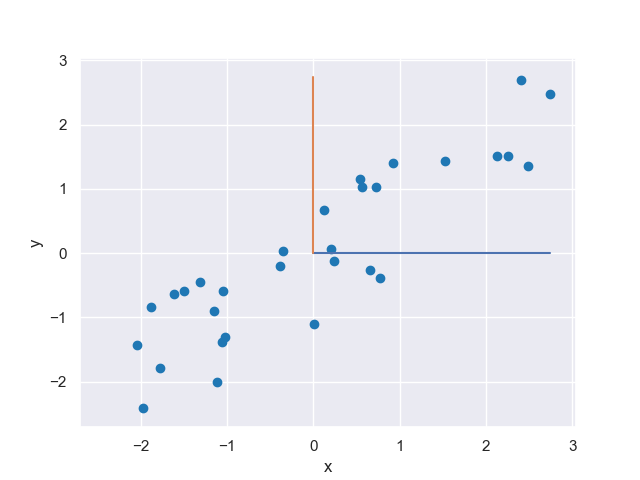

In [9]:
Z = np.matmul(PP, X.T).T
fig, ax = plot_data(Z)
plt.show()

## Covariance of Z
Because of the reduction we now lost some variance.

In [10]:
print_covar(np.cov(Z.T))

covariance matrix:


array([[2.14, 1.72],
       [1.72, 1.75]])

total variance:   2.14 + 1.75   =   3.89


## PCA
**PCA can be seen as merely doing a rotation before doing Feature Selection to preserve the maximum amount of variance**. To see this we first need to understand that the covariance matrix represents the spread in a multivariate normal distribution of the data points and can be repesented by an ellipsoid.

## Covariance as ellipsoid
The diagonal values in a covariance matrix represent the variance on each dimension and determine the size of the ellipsoid. The off-diagonal value represent the covariance between the different dimensions and determine the orientation of the ellipsoid. The ellipsoid we draw here gives the spread of the points at 1 standard deviation.

covariance matrix:


array([[2.14, 0.34, 1.72],
       [0.34, 0.33, 0.27],
       [1.72, 0.27, 1.75]])

total variance:   2.14 + 0.33 + 1.75   =   4.22


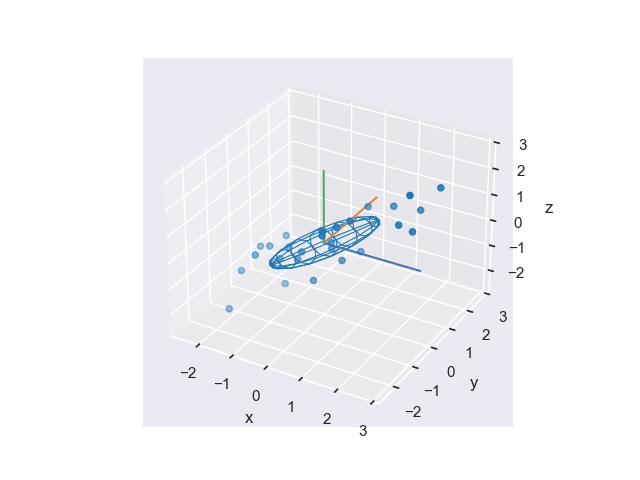

In [11]:
covar = np.cov(X.T)
print_covar(covar)

ellipsoid = create_ellipsoid(covar, 1)

fig,ax=plot_data(X)
draw_ellipsoid(ax, ellipsoid)
plt.show()

## Eigenvectors as basis
The eigenvectors of a covariance matrix give the basis vectors for it orientation, her indicted in red.

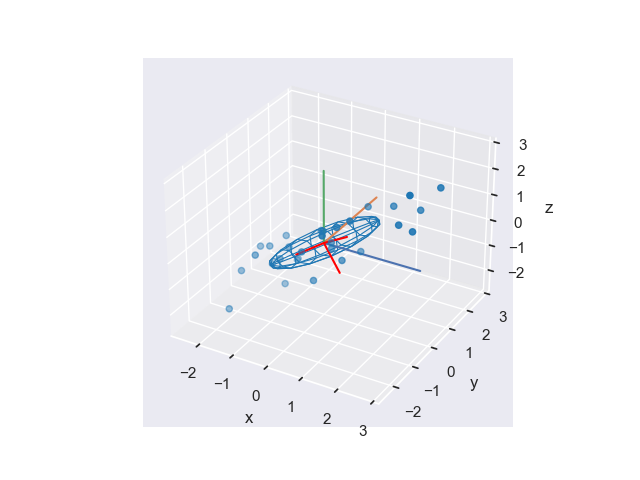

In [12]:
EigVec, EigVal, V = np.linalg.svd(covar)

fig,ax=plot_data(X)
draw_ellipsoid(ax, ellipsoid)
draw_lines(ax, np.zeros(EigVec.shape), EigVec.T, color=red)
plt.show()

## Rotate using eigenvector basis
PCA is just doing the opposite rotation so that the points and their ellipsoid are axis-aligned.

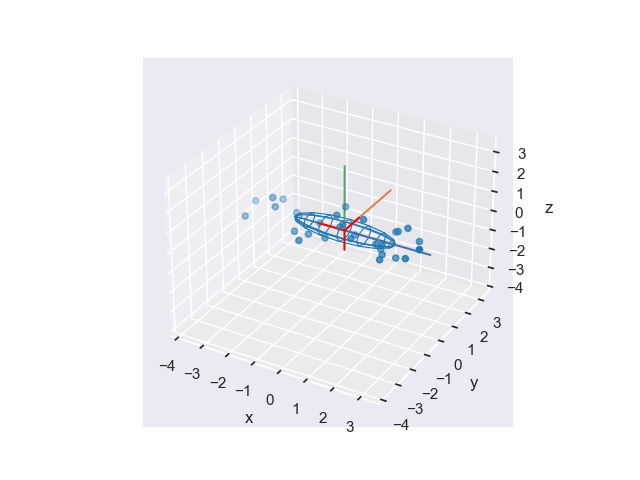

In [13]:
X = np.matmul(EigVec.T, X.T).T

covar = np.cov(X.T)
EigVec, EigVal, V = np.linalg.svd(covar)
ellipsoid = create_ellipsoid(covar,1)

fig,ax=plot_data(X)
draw_ellipsoid(ax, ellipsoid)
draw_lines(ax, np.zeros(EigVec.shape), EigVec.T, color=red)
plt.show()

As a result:

The off-diagonal covariance values are now all zero. Having no covariance means the each dimension is now independent of the others, known the x of a data point no longer gives any information about its y, P(y)=P(y|x). 

The diagonal variance values are ordered high to low and are maximized in that order. The total variance hasn't changed because with a rotation we don't loose any variance (all information, distances between all points, is preserved).

In [14]:
print_covar(np.cov(X.T))

covariance matrix:


array([[ 3.74, -0.  ,  0.  ],
       [-0.  ,  0.28,  0.  ],
       [ 0.  ,  0.  ,  0.2 ]])

total variance:   3.74 + 0.28 + 0.20   =   4.22


## Feature Selection
After doing this rotation all that is left to do to complete the PCA dimensionality reduction is just Features Selection.

P:


array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 0]])

PP:


array([[1, 0, 0],
       [0, 1, 0]])

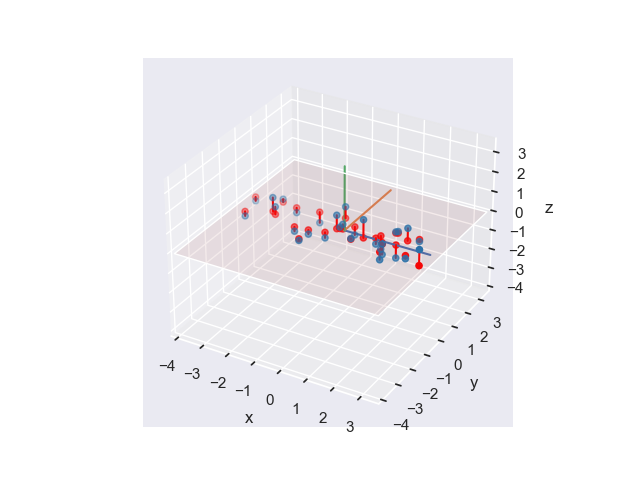

In [15]:

P, PP = get_feature_selection_matrix(X, X.shape[1]-1)
print("P:")
display(P)
print("PP:")
display(PP)

Z = np.matmul(P, X.T).T

fig,ax=plot_data(X)
draw_plane(ax,X,"xy")
draw_points(ax,Z,color=red)
draw_lines(ax,X,Z,color=red)

plt.show()

## PCA result
Which gives us Z, the points in X reduced by one dimension while preserving as much variance as possible.

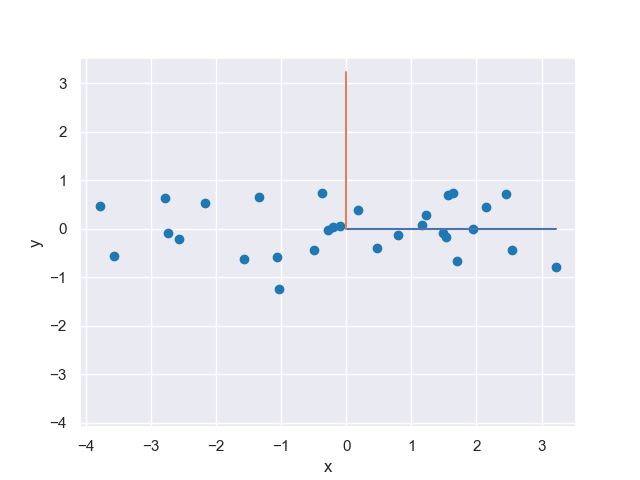

In [16]:
Z = np.matmul(PP, X.T).T
fig,ax=plot_data(Z)
plt.show()

## Covariance of Z
Because of the rotation the total variance of Z is now higher than with just Feature Selection alone. The variance is maximized, there is no rotation that would preserve even more variance. A disadvantage of the rotation is that now the resulting features are a lineair combination of the original features and harder to interpret.

In [17]:
print_covar(np.cov(Z.T))

covariance matrix:


array([[ 3.74, -0.  ],
       [-0.  ,  0.28]])

total variance:   3.74 + 0.28   =   4.02


# The Math

|symbol||meaning|
|------||-------|
|$X$||$N \times D$ data matrix centered on origin|
|$V$||$D \times D$ eigenvector matrix|
|$P$||$K \times D$ feature selection matrix|
|$Z$||$N \times K$ resulting dimensionality reduced matrix|


PCA can thus be seen as applying the reverse rotation of $V$ to $X$ ($V$ is orthogonal, it's reverse rotation is $V^{-1}=V^\top$) followed by feature selection $P$:

$$
\begin{align}
Z^\top = P (V^\top X^\top)
\end{align}
$$

However applying the feature selection matrix $P$ to $V$ first is more efficient:

$$
\begin{align}
Z^\top = (P V^\top) X^\top
\end{align}
$$

More often PCA is written in a form that takes the transpose on both sides:

$$
\begin{align}
Z &= ((P V^\top) X^\top)^\top \\
Z &= X (P V^\top)^\top \\
Z &= X V P^\top \\
Z &= X W
\end{align}
$$
Where $W$ is a matrix with the K eigenvectors of highest eigenvalue as column vectors. These forms are of course all equivalent. Geometrically I feel that the form that rotates the data so that the covariance matrix ellipsoid is axis-aligned is most intuitive.